In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

C:\Users\Raul\anaconda3\envs\ObjectDetection\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda NVIDIA GeForce GTX 1650


(4808, 3024, 3)


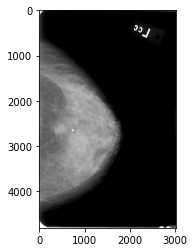

In [3]:
# input image could be of any size
img0 = cv2.imread('P_00001_LEFT_CC.png')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) 
print(img0.shape)
plt.imshow(img0)
plt.show()

In [4]:
# Object information: a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels 
bbox0 = np.array([[2500, 300, 2800, 700]]) 
labels = np.array([1]) # 0: background, 1: helmet

1


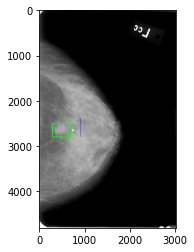

In [5]:
# display bounding box and labels
img0_clone = np.copy(img0)
print(len(bbox0))
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=20) 
    cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 20, (0,0,255),thickness=3) 
plt.imshow(img0_clone)
plt.show()   

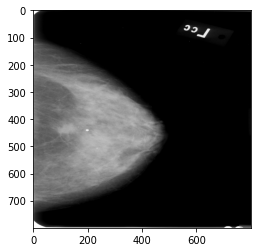

In [6]:
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [7]:
# change the bounding box coordinates 
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bbox0:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[415  79 465 185]]


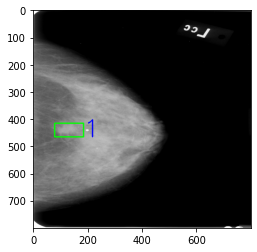

In [8]:
# display bounding box and labels
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) # Write the prediction class
plt.imshow(img_clone)
plt.show()    

In [9]:
# List all the layers of VGG16
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))

31


In [10]:
type(img_clone)

numpy.ndarray

In [11]:
type(a)
a=(1, 3, 800, 800)
type(a)

NameError: name 'a' is not defined

In [13]:
device = torch.device("cuda")
im_tensor = img_clone
dims=im_tensor.shape
inputs = torch.reshape(torch.from_numpy(im_tensor).float(),[1,dims[2],dims[0],dims[1]])
inputs.shape

torch.Size([1, 3, 800, 800])

In [14]:
# dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800] 
dummy_img = inputs

print(dummy_img.shape)

req_features = []
k = inputs.clone().to(device)
print(len(k))
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:   #800/16=50
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512

torch.Size([1, 3, 800, 800])
1
30
512


In [15]:
# Convert this list into a Sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [16]:
transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
imgTensor = transform(img).to(device) 
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


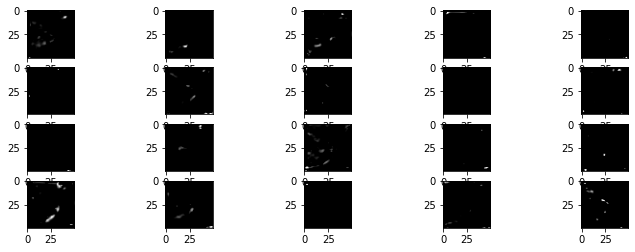

In [19]:
# visualize the first 5 channels of the 50*50*512 feature maps
imgArray=out_map.data.cpu().numpy().squeeze(0)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(20): 
    fig.add_subplot(4, 5, figNo) 
    plt.imshow(imgArray[i], cmap='gray')
    figNo +=1
plt.show()